In [2]:
import numpy as np
import sqlite3
import pandas as pd
from plotnine import *

# Classifiers
## Data Extraction

In [4]:
conn = sqlite3.connect("sabs_moonshot.db")
data = pd.read_sql_query("""
SELECT smiles, fingerprint, r_avg_IC50, f_avg_IC50
FROM assays
INNER JOIN compounds ON compounds.id = assays.compound_id
WHERE assays.r_avg_IC50 != "" OR assays.f_avg_IC50 != "";
""", conn)
pd.to_numeric(data["r_avg_IC50"], errors='coerce')
pd.to_numeric(data["f_avg_IC50"], errors='coerce')
data["r_avg_IC50"] = data["r_avg_IC50"].replace("", np.NaN)
data["f_avg_IC50"] = data["f_avg_IC50"].replace("", np.NaN)
conn.close()
data

,smiles,fingerprint,r_avg_IC50,f_avg_IC50
0,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,0000000000000000000000000000000000000000000000...,NaN,54.272964
1,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,0000000000000000000000000000000000000000000000...,NaN,63.554925
2,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,0000000000000000000000000000000000000000010000...,14.641091,26.680129
3,O=C(Cc1cncc2ccccc12)Nc1ccccc1,0000000000000000000000000000000000000000010000...,45.077469,57.469670
4,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,0000000000000000000000000000000000000000000000...,NaN,99.010000
...,...,...,...,...
2430,N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5c...,0000000000000000000000000000000000000000010000...,NaN,7.793945
2431,CNC(=O)CN1CC2(CCN(c3cncc4cccc(Cl)c34)C2=O)c2cc...,0000000000000000000000000000000000000000010000...,NaN,1.674005
2432,Cc1cnn(C)c1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4c...,0000000000000000000000000000000000000000010100...,NaN,0.682988
2433,Cc1cc(C(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5ccccc4...,0000000000000000000000000000000000000000010000...,NaN,0.463982


Create input and output numpy arrays (X and Y)

In [41]:
X = np.array([[int(c) for c in data["fingerprint"].iloc[i]] for i in range(len(data["fingerprint"]))])
Y = -np.log10(np.mean(data[["r_avg_IC50", "f_avg_IC50"]], axis=1).to_numpy())
Y_raw = Y
Y = Y > np.median(Y)

## Feature Selection
### Remove Low Variance Features

In [42]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold = 0)
X = sel.fit_transform(X)
print(f'{X.shape[1]} Features Remaining')

1322 Features Remaining


### Remove Highly Correlated Features

In [43]:
X = pd.DataFrame(X)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X.drop(to_drop, axis=1, inplace=True)
X = X.to_numpy()
print(f'{X.shape[1]} Features Remaining')

986 Features Remaining


### Split Data into Testing and Training sets

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state = 123456)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (318, 986), X_test shape: (106, 986)
Y_train shape: (318,), Y_test shape: (106,)


/usr/local/anaconda3.7/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 11'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


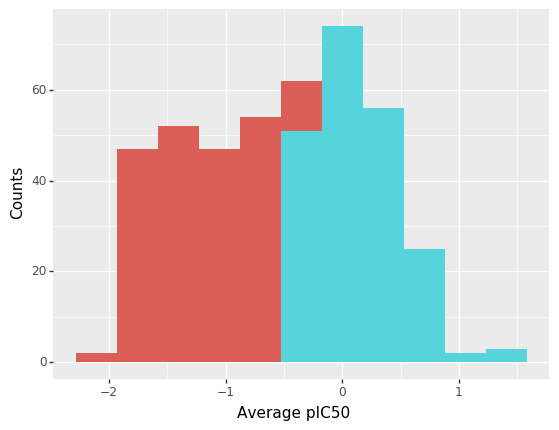

<ggplot: (8731386013037)>

In [46]:
(
    ggplot(pd.DataFrame(X, Y_raw)) +
    geom_histogram(aes(x='Y_raw', fill = (Y_raw>np.median(Y_raw)))) +
    xlab('Average pIC50') + ylab('Counts') + theme(legend_position="none")
)

## Classifier Models
### Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, oob_score=True, random_state=123456)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=123456,
                       verbose=0, warm_start=False)

In [48]:
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_test)
accuracy = accuracy_score(Y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.84
Mean accuracy score: 0.849


### MLP Classifier

In [49]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 5), random_state=1)
clf.fit(X_train, Y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 5), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [50]:
clf_predicted = clf.predict(X_test)
accuracy = accuracy_score(Y_test, clf_predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.84
Mean accuracy score: 0.83


# Regressors
## Data Extraction

In [51]:
conn = sqlite3.connect("sabs_moonshot.db")
data = pd.read_sql_query("""
SELECT smiles, fingerprint, r_avg_IC50, f_avg_IC50
FROM assays
INNER JOIN compounds ON compounds.id = assays.compound_id
WHERE assays.r_avg_IC50 != "" OR assays.f_avg_IC50 != "";
""", conn)
pd.to_numeric(data["r_avg_IC50"], errors='coerce')
pd.to_numeric(data["f_avg_IC50"], errors='coerce')
data["r_avg_IC50"] = data["r_avg_IC50"].replace("", np.NaN)
data["f_avg_IC50"] = data["f_avg_IC50"].replace("", np.NaN)
conn.close()
data = data[data["f_avg_IC50"] < 99]
data = data[data["r_avg_IC50"] < 99]
data

,smiles,fingerprint,r_avg_IC50,f_avg_IC50
2,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,0000000000000000000000000000000000000000010000...,14.641091,26.680129
3,O=C(Cc1cncc2ccccc12)Nc1ccccc1,0000000000000000000000000000000000000000010000...,45.077469,57.469670
5,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,0000000000000000000000000000000000000000010000...,8.201698,4.222340
6,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,0000000000000000000000000000000000000000010000...,13.895165,24.566619
7,Cc1ccncc1NC(=O)Nc1cccc(Cl)c1,0000000000000000000000000000000000000000000000...,45.689263,64.413611
...,...,...,...,...
1616,Cc1ccc(C)c(S(=O)(=O)N2CCN(C(=O)CCl)CC2)c1,0000000000000000000000000000000000000000000000...,1.623369,14.216485
1637,O=C(Nc1cncc2ccccc12)C1CCOc2cc(Cl)c(Cl)cc21,0000000000000000000000000000000000000000000000...,0.309337,0.205428
1711,O=C(CCl)N1CCN(Cc2cccc(Cl)c2)CC1,0000000000000000000000000000000000000000000000...,0.545448,2.536267
1802,O=C(CCl)N1CCN(S(=O)(=O)c2cccc(F)c2)CC1,0000000000000000000000000000000000000000000000...,2.023561,3.666429


Create input and output numpy arrays (X and Y)

In [52]:
X = np.array([[int(c) for c in data["fingerprint"].iloc[i]] for i in range(len(data["fingerprint"]))])
Y = -np.log10(np.mean(data[["r_avg_IC50", "f_avg_IC50"]], axis=1).to_numpy())

## Feature Selection
### Remove Low Variance Features

In [53]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold = 0)
X = sel.fit_transform(X)
print(f'{X.shape[1]} Features Remaining')

1322 Features Remaining


### Remove Highly Correlated Features

In [54]:
X = pd.DataFrame(X)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X.drop(to_drop, axis=1, inplace=True)
X = X.to_numpy()
print(f'{X.shape[1]} Features Remaining')

986 Features Remaining


### Split data into Test and Training Sets

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state = 123456)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (318, 986), X_test shape: (106, 986)
Y_train shape: (318,), Y_test shape: (106,)


/usr/local/anaconda3.7/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 11'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


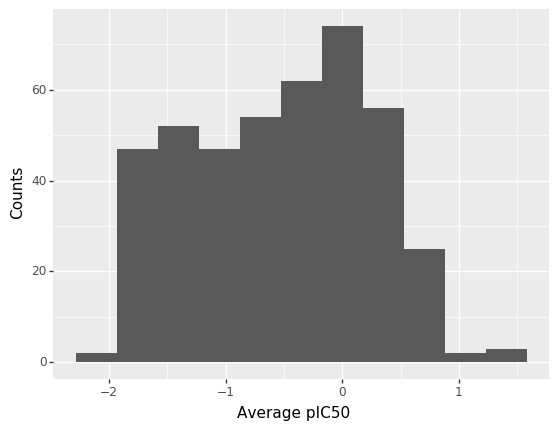

<ggplot: (8731387004025)>

In [56]:
(
    ggplot(pd.DataFrame(X, Y)) +
    geom_histogram(aes(x='Y')) +
    xlab('Average pIC50') + ylab('Counts')
)

## Regression Models
### Create Random Forest Regressor

In [57]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, oob_score=True, random_state=123456)
rf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=123456, verbose=0, warm_start=False)

In [58]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

rf_predicted_train = rf.predict(X_train)
rf_predicted_test = rf.predict(X_test)
test_score = r2_score(Y_test, rf_predicted_test)
spearman = spearmanr(Y_test, rf_predicted_test)
pearson = pearsonr(Y_test, rf_predicted_test)

print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Out-of-bag R-2 score estimate: 0.504
Test data R-2 score: 0.416
Test data Spearman correlation: 0.636
Test data Pearson correlation: 0.659


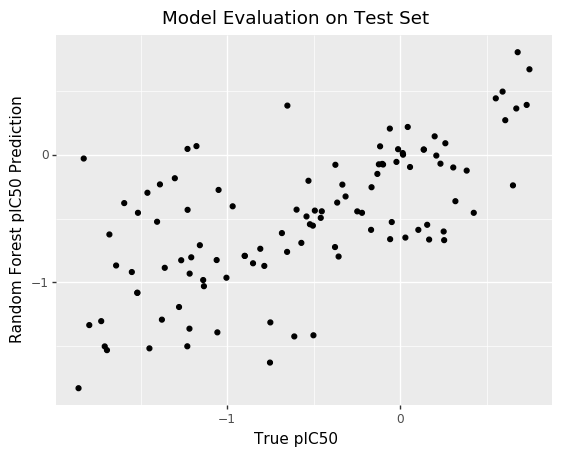

<ggplot: (8731386288945)>

In [67]:
(
    ggplot(pd.DataFrame(Y_test, rf_predicted_test)) +
    geom_point(aes(x='Y_test', y='rf_predicted_test')) +
    xlab('True pIC50') + ylab('Random Forest pIC50 Prediction') +
    ggtitle('Model Evaluation on Test Set')
)

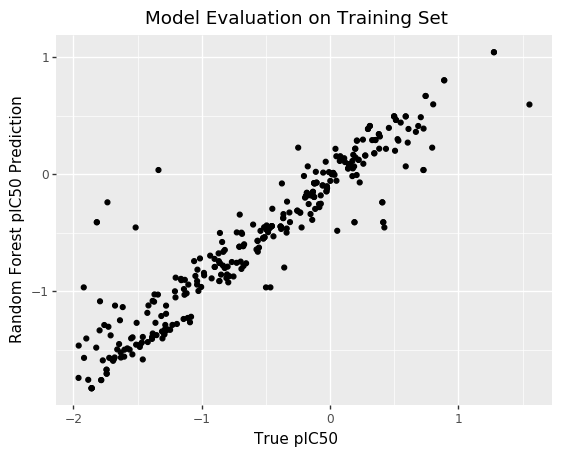

<ggplot: (8731386326509)>

In [68]:
(
    ggplot(pd.DataFrame(Y_train, rf_predicted_train)) +
    geom_point(aes(x='Y_train', y='rf_predicted_train')) +
    xlab('True pIC50') + ylab('Random Forest pIC50 Prediction') +
    ggtitle('Model Evaluation on Training Set')
)

# Create MLP Regressor

In [61]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(10, 5), random_state=1)
mlp.fit(X_train, Y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 5), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [62]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

mlp_predicted_train = mlp.predict(X_train)
mlp_predicted_test = mlp.predict(X_test)
test_score = r2_score(Y_test, mlp_predicted_test)
spearman = spearmanr(Y_test, mlp_predicted_test)
pearson = pearsonr(Y_test, mlp_predicted_test)

print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Test data R-2 score: 0.384
Test data Spearman correlation: 0.638
Test data Pearson correlation: 0.671


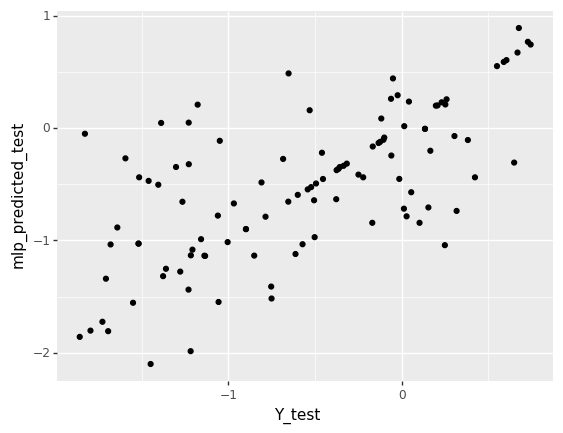

<ggplot: (8731386423237)>

In [63]:
(
    ggplot(pd.DataFrame(Y_test, mlp_predicted_test)) +
    geom_point(aes(x='Y_test', y='mlp_predicted_test')) +
    xlab('True pIC50') + ylab('MLP pIC50 Prediction') +
    ggtitle('MLP Model Evaluation on Test Set')
)

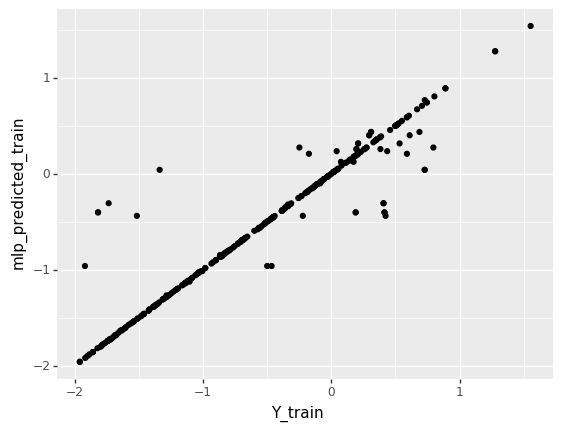

<ggplot: (8731386377025)>

In [64]:
(
    ggplot(pd.DataFrame(Y_train, mlp_predicted_train)) +
    geom_point(aes(x='Y_train', y='mlp_predicted_train')) +
    xlab('True pIC50') + ylab('MLP pIC50 Prediction') +
    ggtitle('MLP Model Evaluation on Training Set')
)